# Annual Race Review

In [2]:
import pandas as pd
import numpy as np
import datetime
import os


# Viz libs
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px

# display options
# pd.options.display.float_format = "{:.2f}".format


import set_config


In [3]:
dir_local = set_config.ConfigSectionMap("SectionOne")['local']
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_race = set_config.ConfigSectionMap("SectionOne")['race']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))
print ("dir_race is %s" % (dir_race))

dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/
dir_race is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Race Dashboard data


In [4]:
folder = 'Race Dashboard data'

file = ('df_weekly_with_calcs.xlsx')

path = os.path.join(dir_race, file)
                    
df = pd.read_excel(path)

df[['OEE %','Changeover','Unplanned_tech_loss','Changeover_rolling_mean', 'OEE_Diff','Changeover_Diff']] = df[['OEE %','Changeover','Unplanned_tech_loss','Changeover_rolling_mean','OEE_Diff','Changeover_Diff']].mul(100)


In [5]:
folder = 'OEE data'


file = ('Duration_of_Changeover.xlsx')

path = os.path.join(dir_sanofi_share, folder, file)
                    
df_duration = pd.read_excel(path,  parse_dates=['Calendar Day'])

file = ('No_of_changeovers.xlsx')
path = os.path.join(dir_sanofi_share, folder, file)

df_changeover_count = pd.read_excel(path)

# df[['OEE %','Changeover','Unplanned_tech_loss','Changeover_rolling_mean', 'OEE_Diff','Changeover_Diff']] = df[['OEE %','Changeover','Unplanned_tech_loss','Changeover_rolling_mean','OEE_Diff','Changeover_Diff']].mul(100)


In [6]:
df_changeover_count['WeekOfYear'] = pd.to_numeric(df_changeover_count['Week'].str[1:3])
df_changeover_count['Year'] = pd.to_numeric(df_changeover_count['Week'].str[4:])
dates = df_changeover_count.Year*100+df_changeover_count.WeekOfYear
df_changeover_count['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
df_changeover_count.head()

,Week,Line,No of Changeovers,WeekOfYear,Year,Date
0,W01-2020,LSX - 1030 Packaging Line,2,1,2020,2020-01-12
1,W01-2020,LSX - 1070-1 Packaging Line,1,1,2020,2020-01-12
2,W01-2020,LSX - 1070-2 Packaging Line,0,1,2020,2020-01-12
3,W01-2020,LSX - C65-1 Packaging Line,0,1,2020,2020-01-12
4,W01-2020,LSX - C65-2 Packaging Line,0,1,2020,2020-01-12


In [7]:
# time data '2021-10-17 00:00:00' does not match format '%d.%m.%Y %H:%M:%S' (match)
# pd.to_timedelta(df_dates.Duration[df_dates['Message Text (English)'].str.contains('1462-7B1')], unit='s')

df_duration['Duration (min)'] = pd.to_datetime(df_duration['Duration (min)'], format='%H:%M:%S', errors='coerce')

In [29]:
df.columns

Index(['Unnamed: 0', 'Week', 'Line', 'OEE %', 'Changeover',
       'Unplanned_tech_loss', 'WeekOfYear', 'Year', 'Date', 'Plant',
       'OEE  Start point', 'Way to Prog Target (65%)', 'McL_Start_OEE',
       'rolling_std', 'Best Solution', 'Best Innovation',
       'Improvement Iterations', 'Lessons and Sharing',
       'Team Contribution and Spirit', 'Changeover times',
       'Number of stoppages', 'Better Together', 'Replicate', 'Review_Date',
       'OEE_Diff', 'Changeover_Diff', 'Changeover_rolling_mean', 'sector_1',
       'sector_2', 'sector_3', 'sector_4', 'sector_5', 'sector_6', 'sector_7',
       'sector_8', 'sector_9', 'sector_10', 'sector_11', 'sector_12',
       'sector_13', 'lap_time', 'Plant Line', 'Process', 'time',
       'Calendar Day', 'No of Changeovers'],
      dtype='object')

31     NaN
39     NaN
53     NaN
58     0.0
73     NaN
      ... 
437    NaN
441    NaN
484    NaN
498    0.0
499    NaN
Name: Changeover times, Length: 505, dtype: float64

In [10]:
df_duration['time'] = df_duration['Duration (min)'] - pd.to_datetime('1900-01-01 00:00:00')
df_duration.sort_values('time', ascending=False)
df_duration_grouped = df_duration.set_index('Calendar Day').groupby(['Line', pd.Grouper(freq='W')]).sum().reset_index()
df = df.merge(df_duration_grouped[['Line','time', 'Calendar Day']], left_on=['Line', 'Date'], right_on=['Line','Calendar Day'])
df = df.merge(df_changeover_count[['Line','Date','No of Changeovers']], on=['Line', 'Date'])

In [11]:
df_duration.groupby(['Line']).time.sum()

Line
ELB - FERMENTATION E05       4 days 06:00:37
ELB - FERMENTATION E06       4 days 15:48:36
ELB - FERMENTATION E07       4 days 21:21:02
ELB - FERMENTATION E08       5 days 02:38:27
ELB - FERMENTATION E09       4 days 23:27:04
                                   ...      
WAT - AIL1 Packaging         2 days 17:59:48
WAT - AIL2 ASSEMBLY          0 days 22:32:03
WAT - AIL2 Packaging         1 days 19:45:50
WAT - LYO Packaging Line 3   2 days 04:47:12
WAT - LYO Packaging Line 9   4 days 03:35:39
Name: time, Length: 201, dtype: timedelta64[ns]

In [12]:
# if time is greater than 0 there should be at least 1 changeover
df.loc[(df['time']>pd.to_timedelta(0)) & (df['No of Changeovers'] == 0), 'No of Changeovers'] = 1

Text(0, 0.5, 'Changeover')

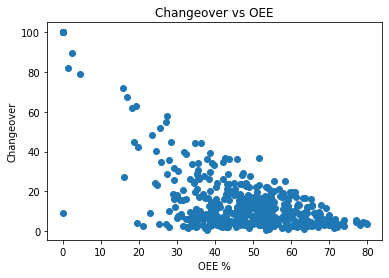

In [13]:
x = df['OEE %']
y = df['Changeover']

plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Changeover vs OEE')
plt.xlabel('OEE %')
plt.ylabel('Changeover')

Text(0, 0.5, 'Changeover')

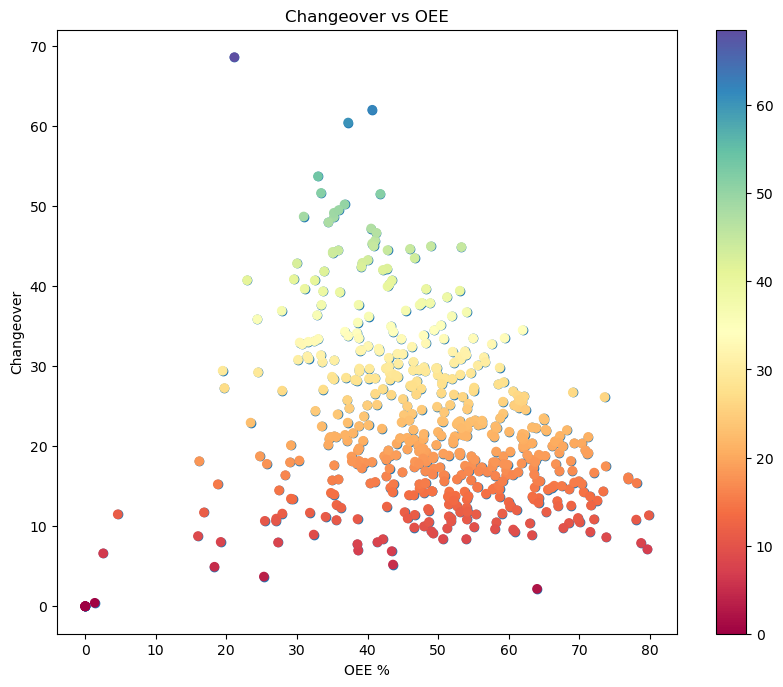

In [14]:
x = df['OEE %']
y = df['Unplanned_tech_loss']
colors = df['Line']

plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Changeover vs OEE')
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.xlabel('OEE %')
plt.ylabel('Changeover')

<AxesSubplot:title={'center':'Changeover SFI'}, xlabel='Date'>

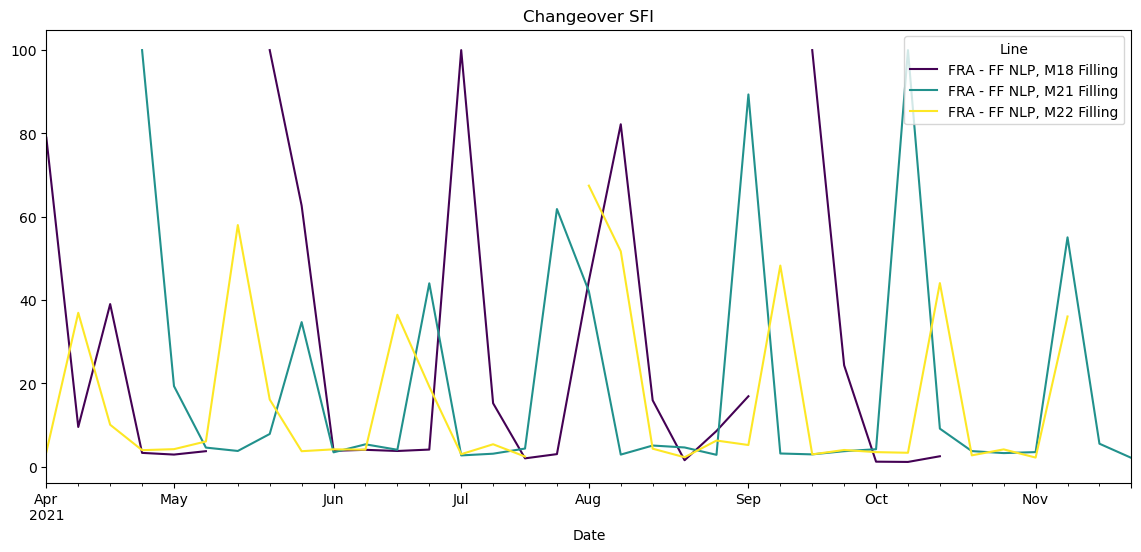

In [15]:
df.pivot_table(index='Date', columns='Line', values='Changeover').filter(regex='M18|M21|M22').plot(figsize=(14,6), title='Changeover SFI', cmap='viridis')

# sns.lineplot(data=df, x='Date', y='Changeover')

In [16]:
pivot_cols = df.pivot_table(index='Date', columns='Line', values='Changeover_rolling_mean').columns
packaging = pivot_cols[~pivot_cols.str.contains('M18|M21|M22')]
filling = pivot_cols[pivot_cols.str.contains('M18|M21|M22')]

In [17]:
px.line(df[df.Line.isin(packaging)], x='Date', y='Changeover_rolling_mean', 
    title='Changeover rolling mean for PACKAGING lines',
    color='Line',
    range_y=(0,40)
    )

In [18]:
px.line(df[df.Line.isin(filling)], x='Date', y='Changeover_rolling_mean', 
    title='Changeover rolling mean for FILLING lines',
    color='Line',
    range_y=(0,100))

In [19]:
# import plotly.graph_objects as go # or plotly.express as px
# # fig = px.lineplot(data=df, x=df['Date'], y=df['Changeover_rolling_mean'], hue='Line')
# fig = px.line(df, x='Date', y='Changeover_rolling_mean', color='Line')
# # fig = go.Figure() # or any Plotly Express function e.g. px.bar(...)


# import dash
# from dash import dcc
# import dash_html_components as html

# app = dash.Dash()
# app.layout = html.Div([
#     dcc.Graph(figure=fig)
# ])

# app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

In [20]:
df.sort_values(['Line','Date'], inplace=True)
df[df.Line == 'FRA - FF NLP, M18 Filling'][['Changeover','Changeover_rolling_mean']]

,Changeover,Changeover_rolling_mean
0,78.978102,78.978102
18,9.540429,44.259265
27,39.041677,42.520069
33,3.324100,32.721077
46,2.918981,13.706297
60,3.733135,12.254473
88,100.000000,26.663029
97,62.659033,41.598042
127,3.818452,41.619371
138,4.059761,42.634312


In [21]:
fig = px.line(df, x='Date', y='Changeover_rolling_mean', 
              color='Line', width=800, height=500,
             title='Rolling Average of Changeover')
fig.show()
file = 'line.html'
path = os.path.join(dir_local, file)
fig.write_html(path)

In [22]:
px.bar(df.groupby('Line').Changeover_rolling_mean.mean().sort_values(ascending=False), 
       orientation='h',
      title='Average Changeover_rolling_mean')

In [78]:
px.bar(df.groupby('Line').Changeover.sum().sort_values(ascending=False), 
       orientation='h',
      title='Using sum of Changeover')

In [79]:
# recalc the diff in case of missing lines of data
df.sort_values(by=['Line','Date'])
# fillna with 0 - otherwise the unplanned_diff calc won't add up.
df['Changeover_Diff'] = df.groupby(['Line'])['Changeover'].diff().fillna(0)

In [80]:
fig = px.bar(round(df.groupby('Line').Changeover_Diff.sum().sort_values(ascending=False),0), x='Changeover_Diff', 
       orientation='h',
      title='Difference in Changeover',
      labels={'Changeover_Diff': 'Point of OEE'},
      text='Changeover_Diff')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')   
# fig.update.xaxis.tickfont = dict(color = 'rgba(0,0,0,0)')


In [81]:
fig = px.bar(df.groupby('Line').Unplanned_tech_loss.sum().sort_values(), x='Unplanned_tech_loss', 
       orientation='h',
      title='Unplanned_tech_loss',
      text='Unplanned_tech_loss')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')   

fig.show()

In [82]:
# now calculate the avg changeover
df['avg_changeover_time'] = df['time'] / df['No of Changeovers']

In [83]:
fig = px.line(df[df.Line.isin(packaging)], x='Date', y='avg_changeover_time', 
              color='Line', width=1000, height=600,
             title='avg time in changeover')
fig.show()
# file = 'line.html'
# path = os.path.join(dir_local, file)
# fig.write_html(path)

In [84]:
fig = px.scatter(df, x='Date', y='No of Changeovers', width=1000, height=600,
             color='Line', title='No of Changeovers', trendline='ols')
fig.show()

In [85]:
fig = px.scatter(df, x='OEE %', y='time', width=800, height=500,
             color='Line', title='time in changeover')
fig.show()

In [86]:
df.sort_values(by=['Line','Date'])
# fillna with 0 - otherwise the unplanned_diff calc won't add up.
df['Unplanned_diff'] = df.groupby(['Line'])['Unplanned_tech_loss'].diff().fillna(0)

In [87]:
df[['Line','Date','Unplanned_tech_loss','Unplanned_diff']][df.Line.str.contains('GAMMA')].sum()

Line                   SCO - GAMMA1SCO - GAMMA1SCO - GAMMA1SCO - GAMM...
Unplanned_tech_loss                                           559.676598
Unplanned_diff                                                -17.132747
dtype: object

In [88]:
fig = px.bar(round(df.groupby(['Line'])['Unplanned_diff'].sum().sort_values(ascending=False), 0), x='Unplanned_diff', 
    orientation='h',
    title='Difference in unplanned_tech_loss',
    labels={"Unplanned_diff": "Point of OEE%"},
    text='Unplanned_diff'
    )
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')   


In [89]:
px.line(df, x='Date', y='Unplanned_tech_loss',
    title='Unplanned_tech_loss',
    color='Line',
    labels={"Unplanned_tech_loss": "Point of OEE%"}
    )

In [90]:
df[['Line','Unplanned_tech_loss','Date','Unplanned_diff']][df.Line.str.contains('GAMMA')]

,Line,Unplanned_tech_loss,Date,Unplanned_diff
7,SCO - GAMMA1,29.138889,2021-04-04,0.000000
15,SCO - GAMMA1,31.927594,2021-04-11,2.788705
25,SCO - GAMMA1,13.883738,2021-04-18,-18.043856
41,SCO - GAMMA1,20.066918,2021-04-25,6.183180
50,SCO - GAMMA1,17.987383,2021-05-02,-2.079535
64,SCO - GAMMA1,16.392766,2021-05-09,-1.594617
78,SCO - GAMMA1,19.691400,2021-05-16,3.298635
83,SCO - GAMMA1,19.332479,2021-05-23,-0.358922
109,SCO - GAMMA1,17.926705,2021-05-30,-1.405774
115,SCO - GAMMA1,18.054563,2021-06-06,0.127859


In [91]:
df.sort_values(['Line','Date'], inplace=True)
df['OEE_Diff_2'] = df.groupby(['Line'])['OEE %'].diff()

In [92]:
fig = px.bar(df.groupby(['Line']).OEE_Diff_2.sum().sort_values(ascending=False), x='OEE_Diff_2', orientation='h',
    labels={'OEE_Diff_2': 'Point of OEE'},
    width=1000, height=600,
    text='OEE_Diff_2',
    title='Difference in OEE')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

In [93]:
px.line(df, x='Date', y='OEE %',
    title='OEE %',
    color='Line',
    width=1000, height=600,
    labels={"OEE %": "Point of OEE%"}
    )

In [94]:
df[['Line','OEE %','Date','OEE_Diff','OEE_Diff_2']][df.Line.str.contains('M22')]

,Line,OEE %,Date,OEE_Diff,OEE_Diff_2
3,"FRA - FF NLP, M22 Filling",64.933565,2021-04-04,11.926774,NaN
12,"FRA - FF NLP, M22 Filling",42.731634,2021-04-11,-22.201930,-22.201930
21,"FRA - FF NLP, M22 Filling",52.051124,2021-04-18,9.319490,9.319490
36,"FRA - FF NLP, M22 Filling",70.370271,2021-04-25,18.319147,18.319147
48,"FRA - FF NLP, M22 Filling",70.846346,2021-05-02,0.476075,0.476075
65,"FRA - FF NLP, M22 Filling",58.540691,2021-05-09,-12.305655,-12.305655
76,"FRA - FF NLP, M22 Filling",27.325101,2021-05-16,-31.215590,-31.215590
82,"FRA - FF NLP, M22 Filling",53.087382,2021-05-23,25.762281,25.762281
106,"FRA - FF NLP, M22 Filling",70.619163,2021-05-30,17.531781,17.531781
113,"FRA - FF NLP, M22 Filling",71.140010,2021-06-06,0.520847,0.520847


In [95]:
fig = px.bar(df.groupby(['Line'])['rolling_std'].mean().sort_values(ascending=False), orientation='h',
    width=1000, height=600,
    title='Average Deviation in OEE')
fig.show()

In [96]:
px.line(df, x='Date', y='rolling_std', color='Line')

In [97]:
y = df['Changeover']
x = np.arange(len(y))
z = np.polyfit(x, y, 3)

In [98]:
p = np.poly1d(z)

In [99]:
p(x)

array([ 8.92058351,  9.06463241,  9.20696433,  9.34758693,  9.48650791,
        9.62373494,  9.75927569,  9.89313784, 10.02532908, 10.15585708,
       10.28472952, 10.41195407, 10.53753842, 10.66149025, 10.78381722,
       10.90452702, 11.02362733, 11.14112582, 11.25703017, 11.37134807,
       11.48408718, 11.59525519, 11.70485978, 11.81290862, 11.91940939,
       12.02436976, 12.12779743, 12.22970006, 12.33008533, 12.42896093,
       12.52633452, 12.62221379, 12.71660642, 12.80952007, 12.90096244,
       12.9909412 , 13.07946403, 13.1665386 , 13.25217259, 13.33637369,
       13.41914956, 13.50050789, 13.58045636, 13.65900264, 13.73615441,
       13.81191935, 13.88630514, 13.95931945, 14.03096997, 14.10126437,
       14.17021033, 14.23781552, 14.30408764, 14.36903434, 14.43266332,
       14.49498224, 14.5559988 , 14.61572066, 14.6741555 , 14.731311  ,
       14.78719485, 14.84181471, 14.89517827, 14.9472932 , 14.99816718,
       15.0478079 , 15.09622302, 15.14342023, 15.1894072 , 15.23

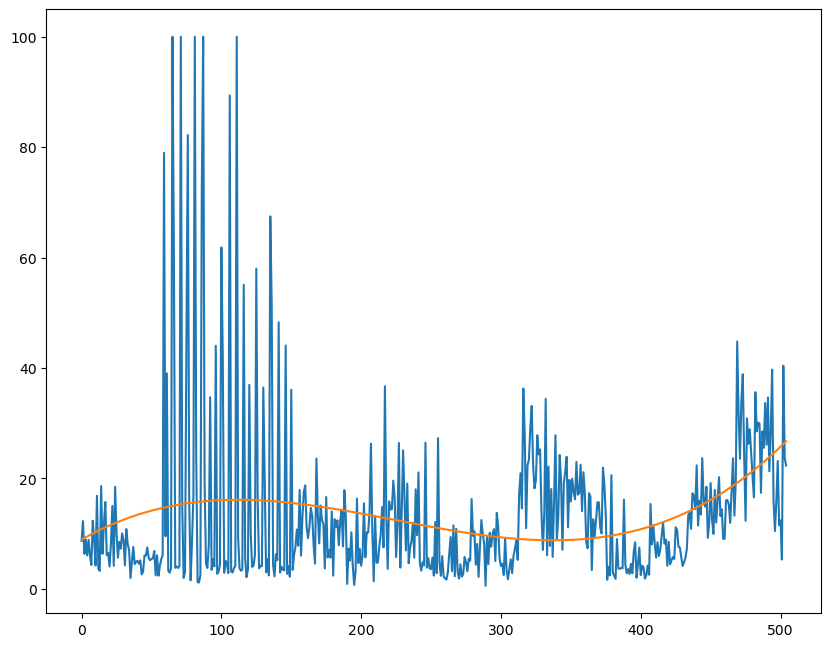

In [100]:

plt.plot(x, y)
plt.plot(x,p(x))
plt.show()

In [101]:
changeover = df.groupby('Line')['Changeover'].sum()
# changeover


In [129]:
int(len(df.Line.unique())/3) + (len(df.Line.unique()) % 3>0)

# df.Line.unique()


7

OEE %


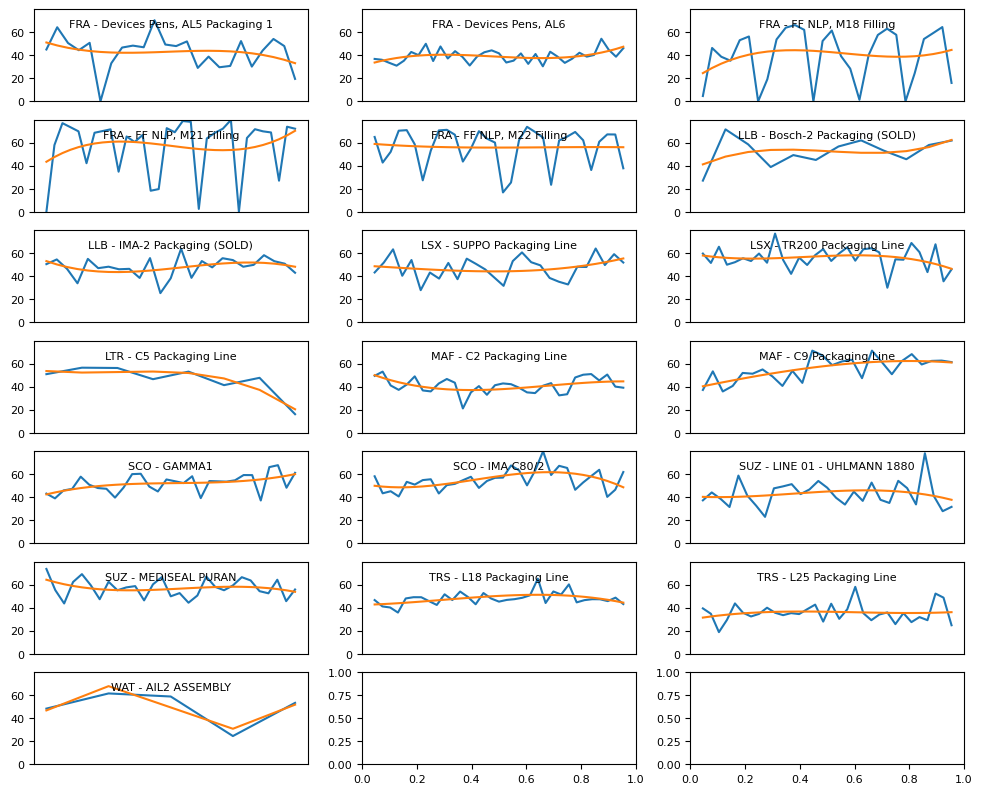

Changeover


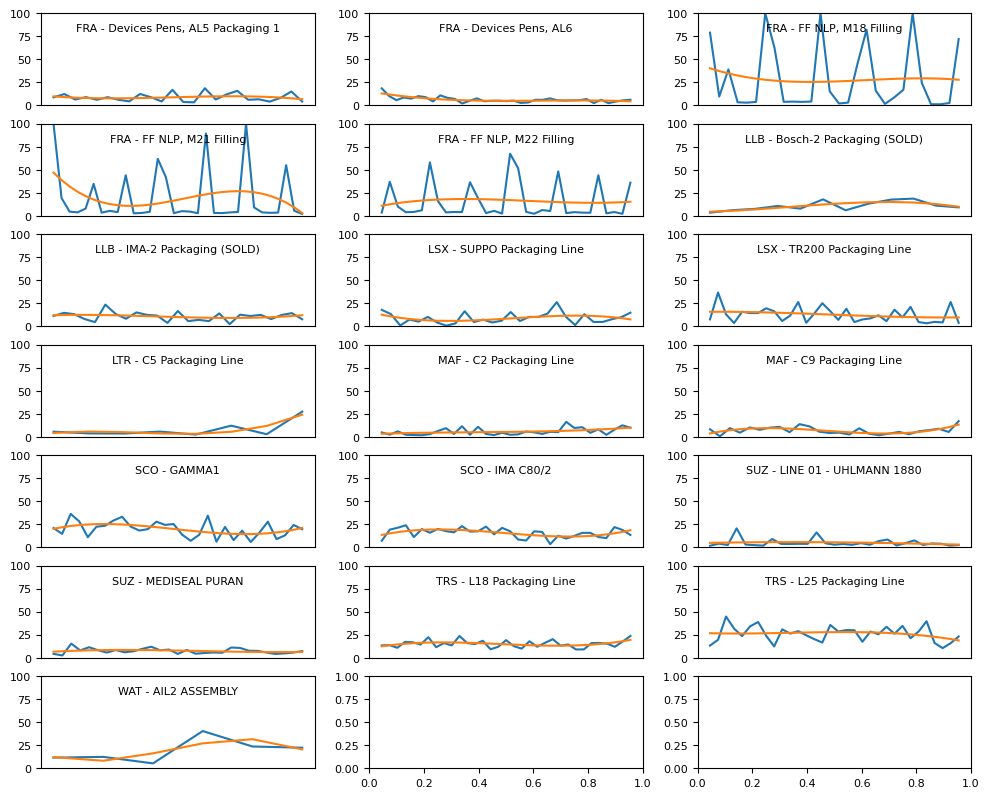

Unplanned_tech_loss


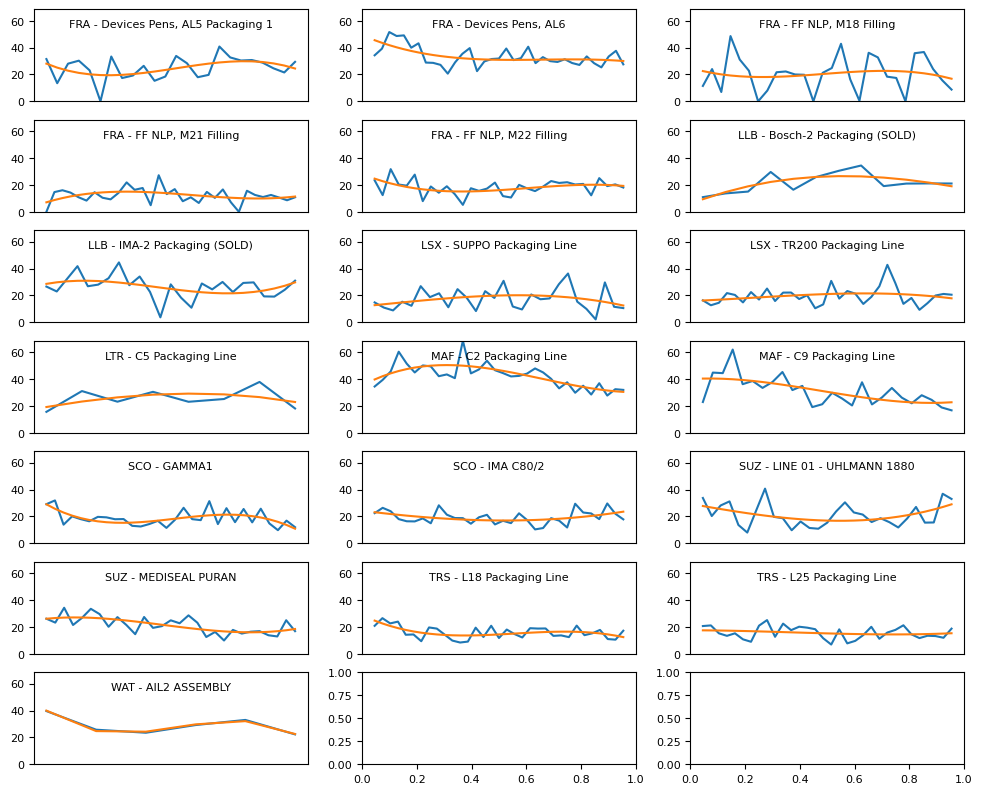

rolling_std


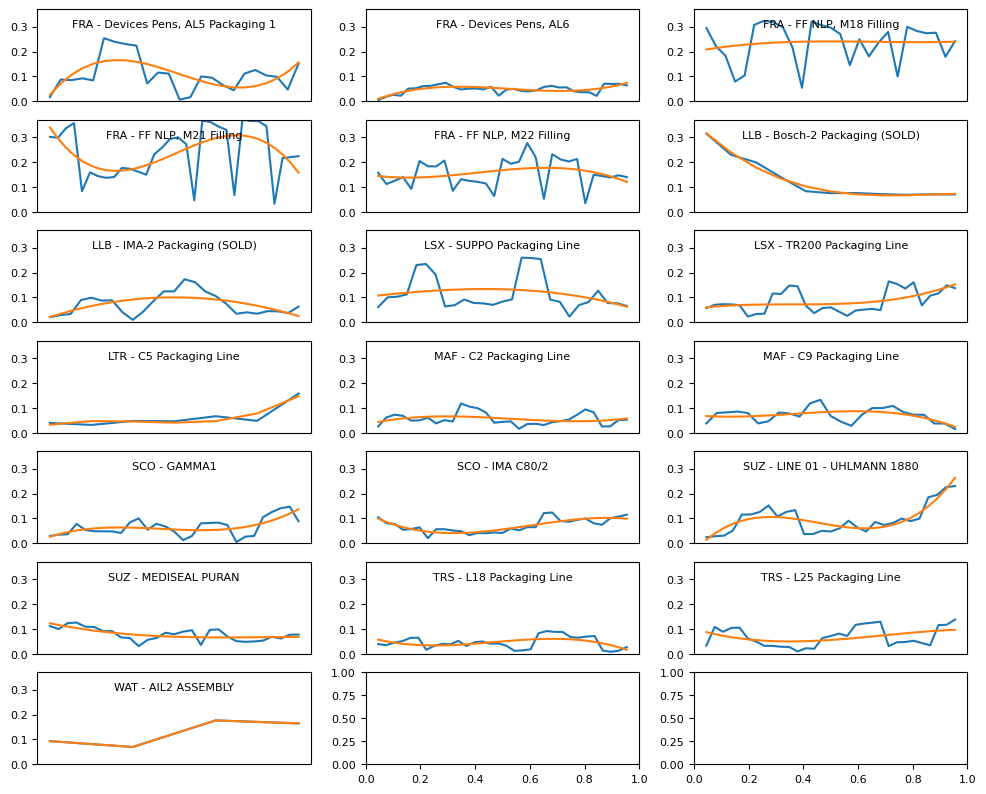

TypeError: '>' not supported between instances of 'Timedelta' and 'int'

In [86]:


metrics = ['OEE %','Changeover','Unplanned_tech_loss','rolling_std','time']

d = {}

myDict={}
df_poly = pd.DataFrame()

for metric in metrics:

    ymax = 0
    
    for line in df.Line.unique():
        # y = df[df.Line == line][metric].dropna() / df[df.Line == line][metric].dropna().sum() * 100
        y = df[df.Line == line][metric].dropna()
        if max(y) > ymax:
            ymax = max(y)

    fig, axs = plt.subplots(int(len(df.Line.unique())/3) + (len(df.Line.unique()) % 3>0),3, figsize=(12,10))

    i=0
    j=0

    for line in df.Line.unique():
        # y = df[df.Line == line][metric].dropna() / df[df.Line == line][metric].dropna().sum() * 100
        y = df[df.Line == line][metric].dropna()
        x = np.arange(len(y))
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)

        axs[i,j].plot(x, y)
        axs[i,j].plot(x,p(x))
        axs[i,j].axes.get_xaxis().set_visible(False)
        axs[i,j].text(0.5, 0.8, line, transform=axs[i,j].transAxes, ha="center")
        axs[i,j].set_ylim(0,ymax)

        if j<2:
            j+=1
        else:
            i+=1
            j=0

        d[metric, line] = round(p(x[-1])-p(x[0]),0)
        myDict = {
            'metric': metric,
            'line': line,
            'start': [p(x[0])],
            'finish': [p(x[-1])],
        }


        df_poly = df_poly.append(pd.DataFrame(myDict))
    print (metric)
    plt.rcParams.update({'font.size': 8})
    plt.show()
print (d)

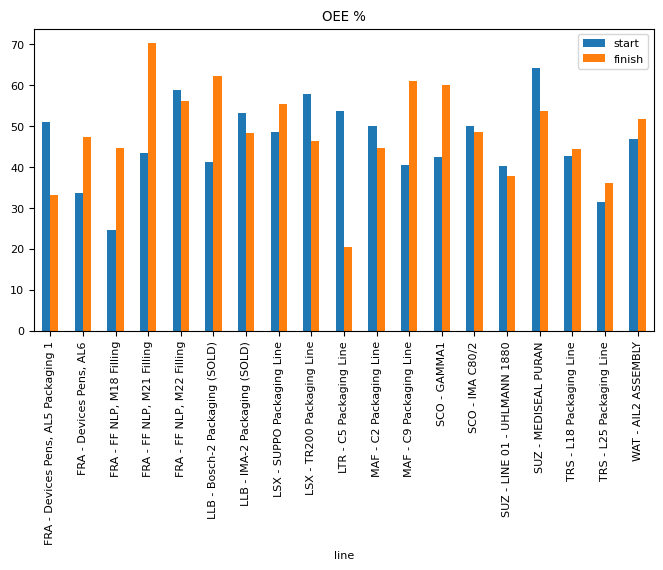

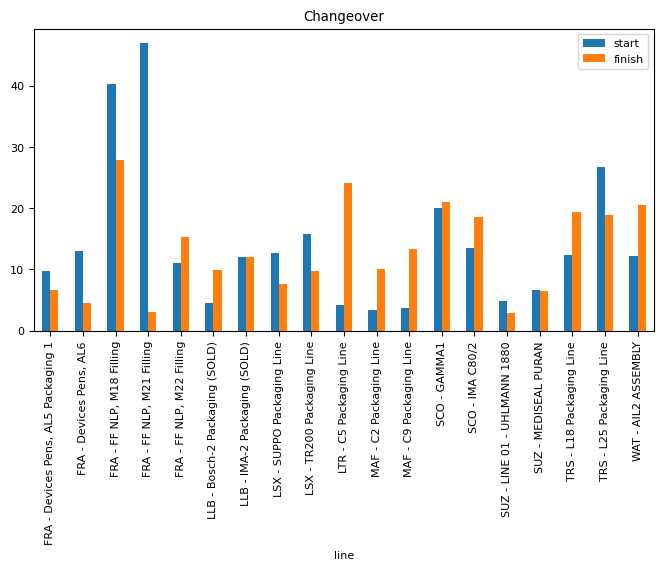

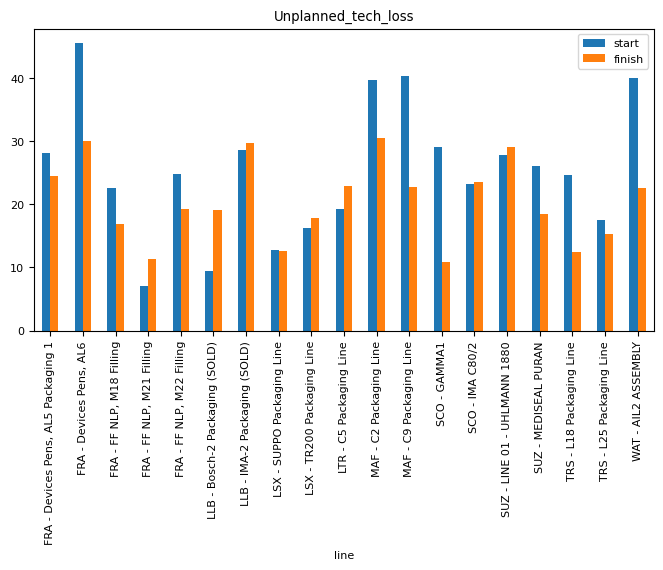

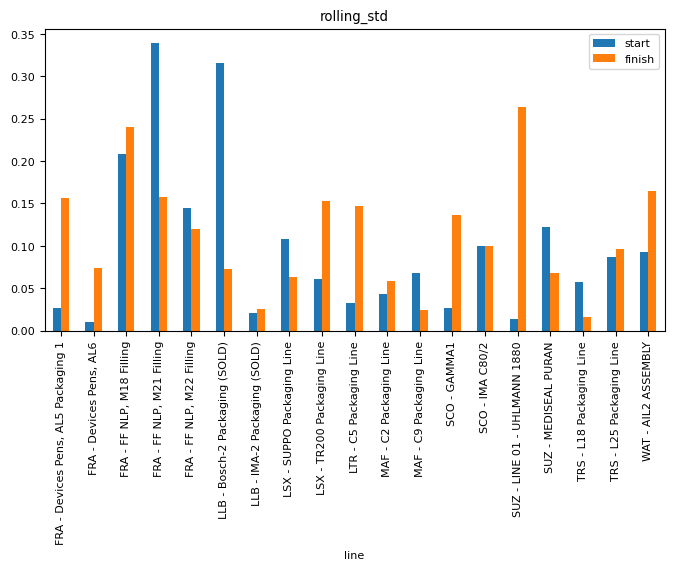

In [37]:
for metric in metrics:
    df_poly[df_poly.metric == metric].groupby(['metric','line']).sum().reset_index().plot.bar(x='line', title=metric, figsize=(8, 4))
    plt.xticks(rotation='vertical')



In [134]:
df_poly = pd.DataFrame(myDict)
df_poly

,metric,line,start,finish
0,rolling_std,WAT - AIL2 ASSEMBLY,18.478493,32.660109


In [135]:
dic2=dict(sorted(d.items(),key= lambda x:x[1]))
print ("Line, Point of OEE")
for key, value in dic2.items():
    print ("{} {}".format(key, value))

Line, Point of OEE
('rolling_std', 'LLB - Bosch-2 Packaging (SOLD)') -17.0
('Unplanned_tech_loss', 'WAT - AIL2 ASSEMBLY') -10.0
('OEE %', 'LTR - C5 Packaging Line') -9.0
('Changeover', 'FRA - FF NLP, M21 Filling') -7.0
('Changeover', 'FRA - Devices Pens, AL6') -4.0
('Unplanned_tech_loss', 'SCO - GAMMA1') -3.0
('rolling_std', 'TRS - L18 Packaging Line') -3.0
('OEE %', 'FRA - Devices Pens, AL5 Packaging 1') -2.0
('Changeover', 'FRA - FF NLP, M18 Filling') -2.0
('Changeover', 'LSX - SUPPO Packaging Line') -2.0
('Changeover', 'LSX - TR200 Packaging Line') -2.0
('Unplanned_tech_loss', 'MAF - C9 Packaging Line') -2.0
('Unplanned_tech_loss', 'TRS - L18 Packaging Line') -2.0
('rolling_std', 'FRA - FF NLP, M21 Filling') -2.0
('rolling_std', 'MAF - C9 Packaging Line') -2.0
('rolling_std', 'SUZ - MEDISEAL PURAN') -2.0
('OEE %', 'LSX - TR200 Packaging Line') -1.0
('OEE %', 'SUZ - MEDISEAL PURAN') -1.0
('Changeover', 'FRA - Devices Pens, AL5 Packaging 1') -1.0
('Changeover', 'SUZ - LINE 01 - UHLMAN

In [136]:
best = min(d, key=d.get)
print(best, d[best])

('rolling_std', 'LLB - Bosch-2 Packaging (SOLD)') -17.0


In [137]:
sorted(d.items(),key= lambda x:x[1])

[(('rolling_std', 'LLB - Bosch-2 Packaging (SOLD)'), -17.0),
 (('Unplanned_tech_loss', 'WAT - AIL2 ASSEMBLY'), -10.0),
 (('OEE %', 'LTR - C5 Packaging Line'), -9.0),
 (('Changeover', 'FRA - FF NLP, M21 Filling'), -7.0),
 (('Changeover', 'FRA - Devices Pens, AL6'), -4.0),
 (('Unplanned_tech_loss', 'SCO - GAMMA1'), -3.0),
 (('rolling_std', 'TRS - L18 Packaging Line'), -3.0),
 (('OEE %', 'FRA - Devices Pens, AL5 Packaging 1'), -2.0),
 (('Changeover', 'FRA - FF NLP, M18 Filling'), -2.0),
 (('Changeover', 'LSX - SUPPO Packaging Line'), -2.0),
 (('Changeover', 'LSX - TR200 Packaging Line'), -2.0),
 (('Unplanned_tech_loss', 'MAF - C9 Packaging Line'), -2.0),
 (('Unplanned_tech_loss', 'TRS - L18 Packaging Line'), -2.0),
 (('rolling_std', 'FRA - FF NLP, M21 Filling'), -2.0),
 (('rolling_std', 'MAF - C9 Packaging Line'), -2.0),
 (('rolling_std', 'SUZ - MEDISEAL PURAN'), -2.0),
 (('OEE %', 'LSX - TR200 Packaging Line'), -1.0),
 (('OEE %', 'SUZ - MEDISEAL PURAN'), -1.0),
 (('Changeover', 'FRA - De

In [138]:
print ("variable of polyfit is " + p.variable)
print ("variables of x are: ")
print (p(x))

variable of polyfit is x
variables of x are: 
[18.47849278 13.81520821 35.04618968 32.66010933]


In [139]:
df.groupby('Line')['Best Solution'].agg(['count','sum']).sort_values(by=['count','sum'],ascending=False)

,count,sum
Line,,
"FRA - Devices Pens, AL6",8,383.0
"FRA - FF NLP, M21 Filling",8,252.0
MAF - C2 Packaging Line,8,189.0
"FRA - Devices Pens, AL5 Packaging 1",8,157.0
TRS - L25 Packaging Line,8,88.0
TRS - L18 Packaging Line,8,87.0
SCO - GAMMA1,7,375.0
MAF - C9 Packaging Line,7,342.0
SCO - IMA C80/2,7,299.0


In [140]:
df[['Line','Date','Best Solution']][df['Best Solution'] > 0].groupby('Line')['Best Solution'].agg(['count','sum']).sort_values(by=['count','sum'],ascending=False)

,count,sum
Line,,
"FRA - Devices Pens, AL6",4,383.0
SCO - GAMMA1,4,375.0
MAF - C9 Packaging Line,4,342.0
SCO - IMA C80/2,3,299.0
"FRA - FF NLP, M21 Filling",3,252.0
"FRA - FF NLP, M22 Filling",3,252.0
MAF - C2 Packaging Line,2,189.0
"FRA - FF NLP, M18 Filling",2,169.0
"FRA - Devices Pens, AL5 Packaging 1",2,157.0


In [141]:
df[['Line','Date','Team Contribution and Spirit']][df['Team Contribution and Spirit'] > 0].groupby('Line')['Team Contribution and Spirit'].agg(['count','sum']).sort_values(by=['count','sum'],ascending=False)

,count,sum
Line,,
SCO - IMA C80/2,6,555.0
SCO - GAMMA1,5,458.0
MAF - C9 Packaging Line,3,264.0
"FRA - Devices Pens, AL6",3,246.0
TRS - L18 Packaging Line,3,212.0
TRS - L25 Packaging Line,3,212.0
"FRA - Devices Pens, AL5 Packaging 1",2,163.0
LLB - IMA-2 Packaging (SOLD),1,174.0
MAF - C2 Packaging Line,1,77.0


In [142]:
# best OEE week
df.groupby(['Date'])['OEE %'].sum().sort_values(ascending=False)

Date
2021-10-24    934.931425
2021-11-07    919.450720
2021-10-17    876.876574
2021-09-19    873.414694
2021-10-03    873.219018
2021-10-31    867.801210
2021-09-26    837.383225
2021-11-14    819.521011
2021-06-20    803.487654
2021-05-09    801.250116
2021-09-12    798.237529
2021-07-18    785.098770
2021-10-10    783.065107
2021-06-06    770.415783
2021-09-05    758.916486
2021-06-13    736.666916
2021-11-21    726.803526
2021-07-11    724.465122
2021-06-27    665.830994
2021-08-08    664.175368
2021-05-23    663.172320
2021-05-30    661.924357
2021-11-28    648.986252
2021-07-04    633.147970
2021-08-29    622.912965
2021-08-22    577.639174
2021-05-02    564.361832
2021-05-16    557.204296
2021-08-01    535.817069
2021-08-15    509.997932
2021-07-25    490.781850
2021-04-18    488.972859
2021-04-04    483.062342
2021-04-25    481.394578
2021-04-11    439.672007
Name: OEE %, dtype: float64

In [279]:
myDict = {'one': 'Ram', 'two': 13, 'three': 'Jordge', 'four': 'Gill', 'five': 33, 'six': 'Steve'};
print(myDict["one"]);

Ram


In [209]:
print(df.time.sum())
df.groupby(['Line']).time.sum().sort_values(ascending=False)

191 days 07:03:10


Line
TRS - L25 Packaging Line              18 days 17:28:40
FRA - FF NLP, M21 Filling             17 days 01:27:11
SCO - IMA C80/2                       15 days 22:57:28
SCO - GAMMA1                          14 days 15:08:57
TRS - L18 Packaging Line              13 days 23:16:37
FRA - FF NLP, M22 Filling             13 days 08:01:33
LLB - IMA-2 Packaging (SOLD)          13 days 05:04:15
FRA - FF NLP, M18 Filling             12 days 08:22:31
FRA - Devices Pens, AL6               11 days 09:50:52
SUZ - MEDISEAL PURAN                  10 days 14:14:56
LSX - TR200 Packaging Line            10 days 11:43:04
LSX - SUPPO Packaging Line             7 days 07:56:51
LLB - Bosch-2 Packaging (SOLD)         6 days 21:45:09
MAF - C2 Packaging Line                6 days 04:04:35
SUZ - LINE 01 - UHLMANN 1880           6 days 02:47:14
FRA - Devices Pens, AL5 Packaging 1    5 days 04:41:31
MAF - C9 Packaging Line                3 days 08:12:36
LTR - C5 Packaging Line                3 days 03:06:58
WAT -

In [47]:
df.set_index('Date', inplace=True)

In [82]:
px.line(df, x='Date',y ='time', color='Line')

In [79]:
df.reset_index(inplace=True)

In [96]:
df

,Date,Unnamed: 0,Week,Line,OEE %,Changeover,Unplanned_tech_loss,WeekOfYear,Year,Plant,...,sector_10,sector_11,sector_12,sector_13,lap_time,Plant Line,Process,time,Calendar Day,No of Changeovers
0,2021-04-18,38,W15-2021,"FRA - Devices Pens, AL5 Packaging 1",44.974540,8.703904,31.496369,15.0,2021.0,Frankfurt,...,0.0,0.0,0.0,0.0,0.449241,"FRA - Devices Pens, AL5 Packaging 1",PACKAGING,0 days 05:40:09,2021-04-18,2
1,2021-04-25,47,W16-2021,"FRA - Devices Pens, AL5 Packaging 1",64.265152,12.272727,13.505051,16.0,2021.0,Frankfurt,...,0.0,0.0,0.0,0.0,0.134643,"FRA - Devices Pens, AL5 Packaging 1",PACKAGING,0 days 01:21:00,2021-04-25,1
2,2021-05-02,65,W17-2021,"FRA - Devices Pens, AL5 Packaging 1",50.580393,6.326097,28.063772,17.0,2021.0,Frankfurt,...,0.0,0.0,0.0,0.0,0.593747,"FRA - Devices Pens, AL5 Packaging 1",PACKAGING,0 days 03:53:07,2021-05-02,2
3,2021-05-09,71,W18-2021,"FRA - Devices Pens, AL5 Packaging 1",44.361140,8.929335,30.288238,18.0,2021.0,Frankfurt,...,0.0,0.0,0.0,0.0,0.548124,"FRA - Devices Pens, AL5 Packaging 1",PACKAGING,0 days 10:40:14,2021-05-09,7
4,2021-05-16,87,W19-2021,"FRA - Devices Pens, AL5 Packaging 1",50.756483,6.057266,23.067261,19.0,2021.0,Frankfurt,...,0.0,0.0,0.0,0.0,0.334624,"FRA - Devices Pens, AL5 Packaging 1",PACKAGING,0 days 06:13:44,2021-05-16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2021-10-31,498,W43-2021,WAT - AIL2 ASSEMBLY,61.445522,12.387785,25.750552,43.0,2021.0,Sanofi Waterford,...,0.0,0.0,0.0,0.0,0.338633,WAT - AIL2 ASSEMBLY,PACKAGING,0 days 03:44:28,2021-10-31,3
501,2021-11-07,502,W44-2021,WAT - AIL2 ASSEMBLY,58.780876,5.310279,23.489657,44.0,2021.0,Sanofi Waterford,...,0.0,0.0,0.0,0.0,0.428537,WAT - AIL2 ASSEMBLY,PACKAGING,0 days 01:52:06,2021-11-07,1
502,2021-11-21,554,W46-2021,WAT - AIL2 ASSEMBLY,24.483234,40.423365,29.212219,46.0,2021.0,Sanofi Waterford,...,0.0,0.0,0.0,0.0,0.991179,WAT - AIL2 ASSEMBLY,PACKAGING,0 days 02:05:43,2021-11-21,1
503,2021-11-28,569,NaN,WAT - AIL2 ASSEMBLY,NaN,23.664815,33.026289,NaN,NaN,Waterford,...,0.0,0.0,0.0,0.0,0.830680,WAT - AIL2 ASSEMBLY,PACKAGING,0 days 10:20:09,2021-11-28,5
